# Pytorch Based Convolutional Autoencoders For Anomaly Detection
useful links:
- [Base autoencoder model](https://www.geeksforgeeks.org/denoising-autoencoders-in-machine-learning/)
- [Batch Normalization Explained](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739)
- [Build a Neural Network in Pytorch](https://towardsdatascience.com/three-ways-to-build-a-neural-network-in-pytorch-8cea49f9a61a)
- [Anomaly Detection With IQR](https://builtin.com/articles/1-5-iqr-rule)

## Initial Setup

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

from torch import nn, optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets
from torchvision.transforms import v2
from torchinfo import summary
from tqdm.auto import tqdm

/home/nata-brain/miniconda3/envs/mpt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Check cuda availability

In [24]:
torch.cuda.is_available()

True

# Set Parameters

In [23]:
# Env Parameters
DATA_DIR='../datasets/cable_dataset_tester/images/dae_dataset'
MODEL_OUT='../models'
GRAPH_OUT='results'
NET_NAME='cable_novelty.pt'

# Hyperparameters
DEVICE = 'cuda'
print(DEVICE)
IMG_SHAPE = (300, 600, 1)

BATCH_SIZE = 32 # originaly 16
LATENT_DIM = 2
LR = 3e-4
EPOCHS = 5000

os.makedirs(MODEL_OUT, exist_ok=True)
os.makedirs(GRAPH_OUT, exist_ok=True)

cuda


## Neural Network Definition

In [25]:
class DAE(nn.Module):
    def __init__(self, img_shape: tuple, latent_dim: int) -> None:
        super(DAE, self).__init__()
        self.img_shape = img_shape
        
        # Deep Neural Network
        self.linear1 = nn.Linear(np.prod(img_shape), 128) # Applies an affine linear transformation to the incoming data: y = x.A^T + b.
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, 512)
        self.linear4 = nn.Linear(512, 256)
        self.linear5 = nn.Linear(256, 128)
        self.linear6 = nn.Linear(128, np.prod(img_shape))
        self.latent1 = nn.Linear(512, latent_dim)
        self.latent2 = nn.Linear(latent_dim, 512)

        self.relu = nn.LeakyReLU(negative_slope=.1, inplace=True)
        self.tanh = nn.Tanh()
    
    def encode(self, x):
        """
        Encoder Creation
        
        Args: 
            x - pixel value
            
        Return:
            Vector encoded
        """
        
        h1 = self.relu(self.linear1(x))
        h2 = self.relu(self.linear2(h1))
        
        return self.relu(self.linear3(h2)) # Encoded data
    
    def decoder(self, z):
        """
        Decoder Creation
        
        Args: 
            z - pixel value
            
        Return:
            Vector decoded 
        """
        
        h4 = self.relu(self.linear4(z))
        h5 = self.relu(self.linear5(h4))
        
        return self.tanh(self.linear6(h5)) # Decoded data
        
    def forward(self, img):
        """
        Feedfoward function to get the reconstructed image
        
        Args: 
            img - image vector
            
        Return:
            Reconstructed vector 
        """
        
        og_shape = img.shape
        img_flat = img.view(img.shape[0], -1)
        z = self.encode(img_flat)
        recon = self.decoder(z)
        
        return recon.view(og_shape) # Reconstructed image vector

# Model creation 

In [27]:
model = DAE(IMG_SHAPE, LATENT_DIM).to(DEVICE)
print(DEVICE)

cuda


In [28]:
summary(model, input_size=(BATCH_SIZE, 1, 600, 300))

Layer (type:depth-idx)                   Output Shape              Param #
DAE                                      [32, 1, 600, 300]         2,562
├─Linear: 1-1                            [32, 128]                 23,040,128
├─LeakyReLU: 1-2                         [32, 128]                 --
├─Linear: 1-3                            [32, 256]                 33,024
├─LeakyReLU: 1-4                         [32, 256]                 --
├─Linear: 1-5                            [32, 512]                 131,584
├─LeakyReLU: 1-6                         [32, 512]                 --
├─Linear: 1-7                            [32, 256]                 131,328
├─LeakyReLU: 1-8                         [32, 256]                 --
├─Linear: 1-9                            [32, 128]                 32,896
├─LeakyReLU: 1-10                        [32, 128]                 --
├─Linear: 1-11                           [32, 180000]              23,220,000
├─Tanh: 1-12                             [32, 18

In [29]:
# loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [30]:
class EarlyStopping:
    def __init__(self, patience:int=5, min_delta:int=0) -> None:
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_val_loss = float('inf')
    
    def early_stop(self, val_loss):
        if val_loss < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0
        elif val_loss > (self.min_val_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

## Loading The Data

In [31]:
img_transforms = v2.Compose([
    v2.Resize(IMG_SHAPE[:-1]),
    v2.Grayscale(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

train_set = datasets.ImageFolder(
    os.path.join(DATA_DIR, 'train'), 
    transform=img_transforms)

train_set, val_set = random_split(train_set, [.7,.3])

In [32]:
train_loader = DataLoader(train_set, BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, BATCH_SIZE, shuffle=False)

## Training

In [33]:
class AutoSave:
    def __init__(self, filename: str) -> None:
        if not filename.endswith('.pt'):
            filename += '.pt'
        self.filename = filename
        self.best_loss = float('inf')
        
    def check_save(self, model, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            torch.save(model.state_dict(), 
                       os.path.join(MODEL_OUT, self.filename))

In [34]:
early_stopping = EarlyStopping(10, .0001)
auto_save = AutoSave(NET_NAME)
history = {'train_loss': [], 'val_loss': []}

# Training Loop
pbar = tqdm(range(EPOCHS), desc='Model Training Progress', position=0)
for epoch in pbar:
    model.train(True)
    train_loss = 0
    val_loss = 0
    
    for i, (data, _) in enumerate(train_loader):
        data = data.to(DEVICE)
        optimizer.zero_grad()
        
        data_noise = torch.randn(data.shape).to(DEVICE)
        data_noise = data + data_noise
        
        recon_batch = model(data_noise.to(DEVICE))
        loss = criterion(recon_batch, data)
        loss.backward()
        
        train_loss += loss.item() * len(data)
        optimizer.step()
        
        pbar.set_postfix({'Step': i+1, 'Train Loss': train_loss/(i+1)})
        
    train_loss = train_loss / len(train_loader)
    model.eval()
    
    with torch.no_grad():
        for j, (vdata, _) in enumerate(val_loader):
            vdata = vdata.to(DEVICE)
            
            vdata_noise = torch.randn(vdata.shape).to(DEVICE)
            vdata_noise = vdata + vdata_noise
            
            vouts = model(vdata_noise.to(DEVICE))
            vloss = criterion(vouts, vdata)
            
            val_loss += vloss.item() * len(vdata)
            
            pbar.set_postfix({
                'Train Loss': train_loss, 
                'Validation Loss': val_loss / (j+1)
            })
            
    val_loss = val_loss / len(val_loader)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    pbar.write(f'Epoch {epoch+1}/{EPOCHS} -> Train loss: {train_loss}, \
        Validation loss: {val_loss}')
    
    auto_save.check_save(model, val_loss)
    
    if early_stopping.early_stop(val_loss):
        print(f'Validation loss did not improve for \
        {early_stopping.patience} epochs, interrupting training.')
        break
    
# pbar.write(f'Final Stats -> Train Loss: {train_loss}, Validation Loss: {val_loss}')

Model Training Progress:   0%|          | 0/5000 [00:21<?, ?it/s, Train Loss=1.14, Validation Loss=0.673]

Epoch 1/5000 -> Train loss: 1.1427144605689254,         Validation loss: 0.6728685024593558


Model Training Progress:   0%|          | 1/5000 [00:45<32:57:30, 23.73s/it, Train Loss=0.621, Validation Loss=0.558]

Epoch 2/5000 -> Train loss: 0.6214222854083301,         Validation loss: 0.5578732430136629


Model Training Progress:   0%|          | 2/5000 [01:10<34:01:02, 24.50s/it, Train Loss=0.514, Validation Loss=0.464]

Epoch 3/5000 -> Train loss: 0.5138373653764373,         Validation loss: 0.4635666819821511


Model Training Progress:   0%|          | 3/5000 [01:34<33:55:12, 24.44s/it, Train Loss=0.435, Validation Loss=0.393]

Epoch 4/5000 -> Train loss: 0.4354478407856877,         Validation loss: 0.39314977400270956


Model Training Progress:   0%|          | 4/5000 [01:58<33:39:52, 24.26s/it, Train Loss=0.374, Validation Loss=0.352]

Epoch 5/5000 -> Train loss: 0.3741268750531542,         Validation loss: 0.3522138810317431


Model Training Progress:   0%|          | 5/5000 [02:23<33:58:13, 24.48s/it, Train Loss=0.338, Validation Loss=0.321]

Epoch 6/5000 -> Train loss: 0.3375788690762286,         Validation loss: 0.3214073548625622


Model Training Progress:   0%|          | 6/5000 [02:46<33:23:40, 24.07s/it, Train Loss=0.316, Validation Loss=0.303]

Epoch 7/5000 -> Train loss: 0.315676248466676,         Validation loss: 0.3032135919268642


Model Training Progress:   0%|          | 7/5000 [03:10<33:07:56, 23.89s/it, Train Loss=0.299, Validation Loss=0.288]

Epoch 8/5000 -> Train loss: 0.2985498629556112,         Validation loss: 0.28790561386517116


Model Training Progress:   0%|          | 8/5000 [03:34<33:06:49, 23.88s/it, Train Loss=0.283, Validation Loss=0.274]

Epoch 9/5000 -> Train loss: 0.28268381861821273,         Validation loss: 0.27438337563404014


Model Training Progress:   0%|          | 9/5000 [03:57<32:54:41, 23.74s/it, Train Loss=0.27, Validation Loss=0.263] 

Epoch 10/5000 -> Train loss: 0.26999003197883537,         Validation loss: 0.26315142533608843


Model Training Progress:   0%|          | 10/5000 [04:20<32:40:39, 23.57s/it, Train Loss=0.258, Validation Loss=0.253]

Epoch 11/5000 -> Train loss: 0.25799596382796397,         Validation loss: 0.2528036898534213


Model Training Progress:   0%|          | 11/5000 [04:43<32:32:14, 23.48s/it, Train Loss=0.249, Validation Loss=0.249]

Epoch 12/5000 -> Train loss: 0.24885475210434088,         Validation loss: 0.24884806642574922


Model Training Progress:   0%|          | 12/5000 [05:06<32:15:47, 23.29s/it, Train Loss=0.241, Validation Loss=0.238]

Epoch 13/5000 -> Train loss: 0.24112460236607886,         Validation loss: 0.23830826466104815


Model Training Progress:   0%|          | 13/5000 [05:30<32:10:45, 23.23s/it, Train Loss=0.234, Validation Loss=0.231]

Epoch 14/5000 -> Train loss: 0.23440944188577265,         Validation loss: 0.23148531699553132


Model Training Progress:   0%|          | 14/5000 [05:54<32:28:47, 23.45s/it, Train Loss=0.23, Validation Loss=0.228] 

Epoch 15/5000 -> Train loss: 0.22968295065720387,         Validation loss: 0.22753841898271016


Model Training Progress:   0%|          | 15/5000 [06:17<32:37:04, 23.56s/it, Train Loss=0.224, Validation Loss=0.222]

Epoch 16/5000 -> Train loss: 0.22425657273070213,         Validation loss: 0.22185123654614602


Model Training Progress:   0%|          | 16/5000 [06:40<32:27:15, 23.44s/it, Train Loss=0.22, Validation Loss=0.218] 

Epoch 17/5000 -> Train loss: 0.2200283367026803,         Validation loss: 0.21793508974037


Model Training Progress:   0%|          | 17/5000 [07:04<32:23:17, 23.40s/it, Train Loss=0.215, Validation Loss=0.213]

Epoch 18/5000 -> Train loss: 0.21495704540262925,         Validation loss: 0.21283038521983794


Model Training Progress:   0%|          | 18/5000 [07:27<32:19:41, 23.36s/it, Train Loss=0.211, Validation Loss=0.21] 

Epoch 19/5000 -> Train loss: 0.21094085925195846,         Validation loss: 0.2103185241376715


Model Training Progress:   0%|          | 19/5000 [07:51<32:21:33, 23.39s/it, Train Loss=0.207, Validation Loss=0.206]

Epoch 20/5000 -> Train loss: 0.20698848311886467,         Validation loss: 0.20621261288012777


Model Training Progress:   0%|          | 20/5000 [08:16<32:49:43, 23.73s/it, Train Loss=0.203, Validation Loss=0.202]

Epoch 21/5000 -> Train loss: 0.20329884316292277,         Validation loss: 0.2018929135120873


Model Training Progress:   0%|          | 21/5000 [08:40<33:07:16, 23.95s/it, Train Loss=0.2, Validation Loss=0.198]  

Epoch 22/5000 -> Train loss: 0.19963349904750755,         Validation loss: 0.19804399522420552


Model Training Progress:   0%|          | 22/5000 [09:03<32:57:45, 23.84s/it, Train Loss=0.196, Validation Loss=0.195]

Epoch 23/5000 -> Train loss: 0.19639303594644816,         Validation loss: 0.19502085583683634


Model Training Progress:   0%|          | 23/5000 [09:29<33:20:00, 24.11s/it, Train Loss=0.193, Validation Loss=0.194]

Epoch 24/5000 -> Train loss: 0.1932184971366192,         Validation loss: 0.19374765497632324


Model Training Progress:   0%|          | 24/5000 [09:53<33:20:06, 24.12s/it, Train Loss=0.191, Validation Loss=0.19] 

Epoch 25/5000 -> Train loss: 0.19099741424519592,         Validation loss: 0.19028042586786406


Model Training Progress:   0%|          | 25/5000 [10:19<33:49:06, 24.47s/it, Train Loss=0.188, Validation Loss=0.188]

Epoch 26/5000 -> Train loss: 0.1882514863566387,         Validation loss: 0.18782962053082883


Model Training Progress:   1%|          | 26/5000 [10:44<34:22:28, 24.88s/it, Train Loss=0.186, Validation Loss=0.185]

Epoch 27/5000 -> Train loss: 0.18621907415199865,         Validation loss: 0.1850220870825329


Model Training Progress:   1%|          | 27/5000 [11:08<34:21:48, 24.88s/it, Train Loss=0.184, Validation Loss=0.184]

Epoch 28/5000 -> Train loss: 0.1839168821832885,         Validation loss: 0.18449907833045082


Model Training Progress:   1%|          | 28/5000 [11:32<33:53:02, 24.53s/it, Train Loss=0.181, Validation Loss=0.182]

Epoch 29/5000 -> Train loss: 0.18143538819865945,         Validation loss: 0.18201372849621944


Model Training Progress:   1%|          | 29/5000 [11:56<33:42:42, 24.41s/it, Train Loss=0.18, Validation Loss=0.181] 

Epoch 30/5000 -> Train loss: 0.1796010735393302,         Validation loss: 0.1806740735258375


Model Training Progress:   1%|          | 30/5000 [12:21<33:41:43, 24.41s/it, Train Loss=0.178, Validation Loss=0.178]

Epoch 31/5000 -> Train loss: 0.17777414976453487,         Validation loss: 0.1775530091420348


Model Training Progress:   1%|          | 31/5000 [12:44<33:35:59, 24.34s/it, Train Loss=0.176, Validation Loss=0.176]

Epoch 32/5000 -> Train loss: 0.1756555992492869,         Validation loss: 0.1761366813377078


Model Training Progress:   1%|          | 32/5000 [13:08<33:15:00, 24.09s/it, Train Loss=0.174, Validation Loss=0.174]

Epoch 33/5000 -> Train loss: 0.17375669612383549,         Validation loss: 0.1737393508997879


Model Training Progress:   1%|          | 33/5000 [13:32<33:11:45, 24.06s/it, Train Loss=0.172, Validation Loss=0.173]

Epoch 34/5000 -> Train loss: 0.17236840009597912,         Validation loss: 0.17324697435168282


Model Training Progress:   1%|          | 34/5000 [13:56<33:21:24, 24.18s/it, Train Loss=0.17, Validation Loss=0.171] 

Epoch 35/5000 -> Train loss: 0.17025942241121655,         Validation loss: 0.17121180654503404


Model Training Progress:   1%|          | 35/5000 [14:19<32:54:56, 23.87s/it, Train Loss=0.169, Validation Loss=0.17] 

Epoch 36/5000 -> Train loss: 0.16907036197057532,         Validation loss: 0.1699924288184515


Model Training Progress:   1%|          | 36/5000 [14:42<32:31:38, 23.59s/it, Train Loss=0.167, Validation Loss=0.168]

Epoch 37/5000 -> Train loss: 0.16731523313313906,         Validation loss: 0.16763721719118102


Model Training Progress:   1%|          | 37/5000 [15:12<34:34:40, 25.08s/it, Train Loss=0.166, Validation Loss=0.167]

Epoch 38/5000 -> Train loss: 0.16565328889006486,         Validation loss: 0.1670218841837985


Model Training Progress:   1%|          | 38/5000 [15:38<34:59:28, 25.39s/it, Train Loss=0.164, Validation Loss=0.166]

Epoch 39/5000 -> Train loss: 0.16423877063521578,         Validation loss: 0.1659347922408155


Model Training Progress:   1%|          | 39/5000 [16:04<35:18:06, 25.62s/it, Train Loss=0.163, Validation Loss=0.163]

Epoch 40/5000 -> Train loss: 0.16327174483267076,         Validation loss: 0.1628157211933285


Model Training Progress:   1%|          | 40/5000 [16:28<34:49:46, 25.28s/it, Train Loss=0.161, Validation Loss=0.162]

Epoch 41/5000 -> Train loss: 0.16139963726324538,         Validation loss: 0.16198015226982534


Model Training Progress:   1%|          | 41/5000 [16:54<35:01:27, 25.43s/it, Train Loss=0.16, Validation Loss=0.161] 

Epoch 42/5000 -> Train loss: 0.1600827716885169,         Validation loss: 0.16087187845925136


Model Training Progress:   1%|          | 43/5000 [17:18<33:01:00, 23.98s/it, Step=4, Train Loss=0.161]               

Epoch 43/5000 -> Train loss: 0.1589394586583588,         Validation loss: 0.16118398951366544


Model Training Progress:   1%|          | 43/5000 [17:39<33:01:00, 23.98s/it, Train Loss=0.158, Validation Loss=0.158]

Epoch 44/5000 -> Train loss: 0.1580046918128897,         Validation loss: 0.1583631848317704


Model Training Progress:   1%|          | 44/5000 [18:03<33:06:01, 24.04s/it, Train Loss=0.157, Validation Loss=0.158]

Epoch 45/5000 -> Train loss: 0.15677910460376301,         Validation loss: 0.15827968803766582


Model Training Progress:   1%|          | 45/5000 [18:26<32:41:26, 23.75s/it, Train Loss=0.156, Validation Loss=0.156]

Epoch 46/5000 -> Train loss: 0.1558389094846746,         Validation loss: 0.15629922078390207


Model Training Progress:   1%|          | 46/5000 [18:49<32:22:34, 23.53s/it, Train Loss=0.155, Validation Loss=0.156]

Epoch 47/5000 -> Train loss: 0.15473309524951537,         Validation loss: 0.15584637935805534


Model Training Progress:   1%|          | 47/5000 [19:12<32:02:18, 23.29s/it, Train Loss=0.154, Validation Loss=0.156]

Epoch 48/5000 -> Train loss: 0.15362767342683728,         Validation loss: 0.1555038866054799


Model Training Progress:   1%|          | 48/5000 [19:36<32:06:55, 23.35s/it, Train Loss=0.153, Validation Loss=0.154]

Epoch 49/5000 -> Train loss: 0.1527088429847378,         Validation loss: 0.15381004604777054


Model Training Progress:   1%|          | 50/5000 [19:59<31:25:50, 22.86s/it, Step=4, Train Loss=0.151]               

Epoch 50/5000 -> Train loss: 0.15188107159605788,         Validation loss: 0.1546422163623252


Model Training Progress:   1%|          | 50/5000 [20:20<31:25:50, 22.86s/it, Train Loss=0.151, Validation Loss=0.152]

Epoch 51/5000 -> Train loss: 0.15093590543131155,         Validation loss: 0.15202322493839476


Model Training Progress:   1%|          | 52/5000 [20:45<31:06:29, 22.63s/it, Step=4, Train Loss=0.163]               

Epoch 52/5000 -> Train loss: 0.1500819515368324,         Validation loss: 0.15224053548382863


Model Training Progress:   1%|          | 52/5000 [21:05<31:06:29, 22.63s/it, Train Loss=0.149, Validation Loss=0.151]

Epoch 53/5000 -> Train loss: 0.14933900425404859,         Validation loss: 0.15063053792608636


Model Training Progress:   1%|          | 53/5000 [21:29<31:18:53, 22.79s/it, Train Loss=0.149, Validation Loss=0.151]

Epoch 54/5000 -> Train loss: 0.1486232248963388,         Validation loss: 0.15061599507794848


Model Training Progress:   1%|          | 54/5000 [21:52<31:12:01, 22.71s/it, Train Loss=0.147, Validation Loss=0.149]

Epoch 55/5000 -> Train loss: 0.14746949092650707,         Validation loss: 0.14947777230824744


Model Training Progress:   1%|          | 56/5000 [22:16<31:01:31, 22.59s/it, Step=4, Train Loss=0.149]               

Epoch 56/5000 -> Train loss: 0.14722484962706187,         Validation loss: 0.14959159436236535


Model Training Progress:   1%|          | 56/5000 [22:36<31:01:31, 22.59s/it, Train Loss=0.146, Validation Loss=0.148]

Epoch 57/5000 -> Train loss: 0.146361471776582,         Validation loss: 0.14840452682359942


Model Training Progress:   1%|          | 57/5000 [22:59<30:50:50, 22.47s/it, Train Loss=0.146, Validation Loss=0.148]

Epoch 58/5000 -> Train loss: 0.14569717839908747,         Validation loss: 0.14776947113818356


Model Training Progress:   1%|          | 58/5000 [23:22<31:14:32, 22.76s/it, Train Loss=0.145, Validation Loss=0.148]

Epoch 59/5000 -> Train loss: 0.1447358441773368,         Validation loss: 0.1476455695594528


Model Training Progress:   1%|          | 59/5000 [23:45<31:15:03, 22.77s/it, Train Loss=0.144, Validation Loss=0.147]

Epoch 60/5000 -> Train loss: 0.1443770274839884,         Validation loss: 0.1466803787409195


Model Training Progress:   1%|          | 60/5000 [24:09<31:44:25, 23.13s/it, Train Loss=0.144, Validation Loss=0.146]

Epoch 61/5000 -> Train loss: 0.14366686001328602,         Validation loss: 0.14646626408211888


Model Training Progress:   1%|          | 61/5000 [24:31<31:13:09, 22.76s/it, Train Loss=0.143, Validation Loss=0.146]

Epoch 62/5000 -> Train loss: 0.14314577607380832,         Validation loss: 0.14613638727792672


Model Training Progress:   1%|          | 62/5000 [24:55<31:41:27, 23.10s/it, Train Loss=0.142, Validation Loss=0.145]

Epoch 63/5000 -> Train loss: 0.14234921557863064,         Validation loss: 0.1449360861243414


Model Training Progress:   1%|▏         | 63/5000 [25:19<32:04:43, 23.39s/it, Train Loss=0.142, Validation Loss=0.144]

Epoch 64/5000 -> Train loss: 0.14190163515919557,         Validation loss: 0.14427200409450702


Model Training Progress:   1%|▏         | 65/5000 [25:43<31:18:27, 22.84s/it, Step=4, Train Loss=0.135]               

Epoch 65/5000 -> Train loss: 0.14124592537620317,         Validation loss: 0.14466282209780598


Model Training Progress:   1%|▏         | 65/5000 [26:05<31:18:27, 22.84s/it, Train Loss=0.141, Validation Loss=0.143]

Epoch 66/5000 -> Train loss: 0.14065413963209633,         Validation loss: 0.14313945665157268


Model Training Progress:   1%|▏         | 66/5000 [26:27<31:26:40, 22.94s/it, Train Loss=0.14, Validation Loss=0.142] 

Epoch 67/5000 -> Train loss: 0.13998836891417124,         Validation loss: 0.14236666839569806


Model Training Progress:   1%|▏         | 68/5000 [26:50<30:45:24, 22.45s/it, Step=4, Train Loss=0.135]               

Epoch 68/5000 -> Train loss: 0.1394455978886847,         Validation loss: 0.14250657450008605


Model Training Progress:   1%|▏         | 68/5000 [27:12<30:45:24, 22.45s/it, Train Loss=0.139, Validation Loss=0.141]

Epoch 69/5000 -> Train loss: 0.13893010343876352,         Validation loss: 0.14147364819821504


Model Training Progress:   1%|▏         | 69/5000 [27:36<31:24:40, 22.93s/it, Train Loss=0.138, Validation Loss=0.141]

Epoch 70/5000 -> Train loss: 0.13844797227737363,         Validation loss: 0.1413800600517009


Model Training Progress:   1%|▏         | 70/5000 [28:00<31:28:07, 22.98s/it, Train Loss=0.138, Validation Loss=0.141]

Epoch 71/5000 -> Train loss: 0.13809988236317605,         Validation loss: 0.14081389691813717


Model Training Progress:   1%|▏         | 72/5000 [28:25<31:48:06, 23.23s/it, Step=4, Train Loss=0.149]               

Epoch 72/5000 -> Train loss: 0.1374445495429946,         Validation loss: 0.14131737362061228


Model Training Progress:   1%|▏         | 72/5000 [28:47<31:48:06, 23.23s/it, Train Loss=0.137, Validation Loss=0.141]

Epoch 73/5000 -> Train loss: 0.13731964142775974,         Validation loss: 0.14054424362922355


Model Training Progress:   1%|▏         | 73/5000 [29:13<32:46:24, 23.95s/it, Train Loss=0.137, Validation Loss=0.141]

Epoch 74/5000 -> Train loss: 0.1369722970287127,         Validation loss: 0.1405091066645192


Model Training Progress:   1%|▏         | 74/5000 [29:39<33:35:33, 24.55s/it, Train Loss=0.136, Validation Loss=0.14] 

Epoch 75/5000 -> Train loss: 0.13593308218509143,         Validation loss: 0.14001026609247283


Model Training Progress:   2%|▏         | 75/5000 [30:04<33:43:24, 24.65s/it, Train Loss=0.136, Validation Loss=0.139]

Epoch 76/5000 -> Train loss: 0.1355127993445455,         Validation loss: 0.1388815360476396


Model Training Progress:   2%|▏         | 76/5000 [30:27<33:25:59, 24.44s/it, Train Loss=0.135, Validation Loss=0.138]

Epoch 77/5000 -> Train loss: 0.13530152336768578,         Validation loss: 0.13765660007484257


Model Training Progress:   2%|▏         | 78/5000 [30:52<32:24:07, 23.70s/it, Step=4, Train Loss=0.139]               

Epoch 78/5000 -> Train loss: 0.1348632030600419,         Validation loss: 0.13796620120826578


Model Training Progress:   2%|▏         | 78/5000 [31:15<32:24:07, 23.70s/it, Train Loss=0.134, Validation Loss=0.137]

Epoch 79/5000 -> Train loss: 0.13442452974114683,         Validation loss: 0.13749629114089268


Model Training Progress:   2%|▏         | 79/5000 [31:40<33:09:29, 24.26s/it, Train Loss=0.134, Validation Loss=0.137]

Epoch 80/5000 -> Train loss: 0.13395283343784647,         Validation loss: 0.13680376362587723


Model Training Progress:   2%|▏         | 81/5000 [32:05<32:47:01, 23.99s/it, Step=4, Train Loss=0.121]               

Epoch 81/5000 -> Train loss: 0.133438980241129,         Validation loss: 0.13707200757094792


Model Training Progress:   2%|▏         | 82/5000 [32:28<32:15:35, 23.61s/it, Step=3, Train Loss=0.126]               

Epoch 82/5000 -> Train loss: 0.13320605961914442,         Validation loss: 0.13743114585855176


Model Training Progress:   2%|▏         | 82/5000 [32:51<32:15:35, 23.61s/it, Train Loss=0.133, Validation Loss=0.136]

Epoch 83/5000 -> Train loss: 0.1329073011646607,         Validation loss: 0.13644810493237206


Model Training Progress:   2%|▏         | 83/5000 [33:16<32:56:50, 24.12s/it, Train Loss=0.132, Validation Loss=0.136]

Epoch 84/5000 -> Train loss: 0.132297834712852,         Validation loss: 0.13572218191277768


Model Training Progress:   2%|▏         | 85/5000 [33:41<32:29:48, 23.80s/it, Step=4, Train Loss=0.135]               

Epoch 85/5000 -> Train loss: 0.13234747054935234,         Validation loss: 0.136636820961056


Model Training Progress:   2%|▏         | 85/5000 [34:03<32:29:48, 23.80s/it, Train Loss=0.132, Validation Loss=0.135]

Epoch 86/5000 -> Train loss: 0.13184968322698323,         Validation loss: 0.13536360513951098


Model Training Progress:   2%|▏         | 86/5000 [34:29<33:16:59, 24.38s/it, Train Loss=0.131, Validation Loss=0.135]

Epoch 87/5000 -> Train loss: 0.1314668303664111,         Validation loss: 0.1349291271596615


Model Training Progress:   2%|▏         | 87/5000 [34:54<33:48:20, 24.77s/it, Train Loss=0.132, Validation Loss=0.135]

Epoch 88/5000 -> Train loss: 0.13167343302372775,         Validation loss: 0.1345812193849789


Model Training Progress:   2%|▏         | 88/5000 [35:19<33:46:31, 24.75s/it, Train Loss=0.131, Validation Loss=0.135]

Epoch 89/5000 -> Train loss: 0.13089481274957307,         Validation loss: 0.1345756176593048


Model Training Progress:   2%|▏         | 90/5000 [35:44<32:48:30, 24.06s/it, Step=4, Train Loss=0.128]               

Epoch 90/5000 -> Train loss: 0.13036559958673694,         Validation loss: 0.13473975261274193


Model Training Progress:   2%|▏         | 90/5000 [36:06<32:48:30, 24.06s/it, Train Loss=0.13, Validation Loss=0.134]

Epoch 91/5000 -> Train loss: 0.1303651507921014,         Validation loss: 0.1338643309992871


Model Training Progress:   2%|▏         | 92/5000 [36:29<31:43:16, 23.27s/it, Step=4, Train Loss=0.139]              

Epoch 92/5000 -> Train loss: 0.1300684488349897,         Validation loss: 0.1342251628903406


Model Training Progress:   2%|▏         | 93/5000 [36:51<31:10:17, 22.87s/it, Step=4, Train Loss=0.126]              

Epoch 93/5000 -> Train loss: 0.1297358375934004,         Validation loss: 0.1343443286538656


Model Training Progress:   2%|▏         | 93/5000 [37:12<31:10:17, 22.87s/it, Train Loss=0.13, Validation Loss=0.133]

Epoch 94/5000 -> Train loss: 0.12983843217963822,         Validation loss: 0.13346617690819715


Model Training Progress:   2%|▏         | 94/5000 [37:37<31:10:47, 22.88s/it, Train Loss=0.129, Validation Loss=0.133]

Epoch 95/5000 -> Train loss: 0.12924687415818495,         Validation loss: 0.1326028981246054


Model Training Progress:   2%|▏         | 96/5000 [38:00<31:07:00, 22.84s/it, Step=4, Train Loss=0.124]               

Epoch 96/5000 -> Train loss: 0.12925366332834484,         Validation loss: 0.13263767611767566


Model Training Progress:   2%|▏         | 96/5000 [38:22<31:07:00, 22.84s/it, Train Loss=0.129, Validation Loss=0.132]

Epoch 97/5000 -> Train loss: 0.12863952787650143,         Validation loss: 0.13224520626743988


Model Training Progress:   2%|▏         | 97/5000 [38:46<31:16:00, 22.96s/it, Train Loss=0.128, Validation Loss=0.132]

Epoch 98/5000 -> Train loss: 0.12834258032448453,         Validation loss: 0.13208370937832764


Model Training Progress:   2%|▏         | 99/5000 [39:10<31:26:14, 23.09s/it, Step=4, Train Loss=0.118]               

Epoch 99/5000 -> Train loss: 0.12835713905607996,         Validation loss: 0.13213185580846454


Model Training Progress:   2%|▏         | 99/5000 [39:32<31:26:14, 23.09s/it, Train Loss=0.128, Validation Loss=0.132]

Epoch 100/5000 -> Train loss: 0.1280352245170646,         Validation loss: 0.13181542899193507


Model Training Progress:   2%|▏         | 100/5000 [39:55<31:26:04, 23.09s/it, Train Loss=0.128, Validation Loss=0.132]

Epoch 101/5000 -> Train loss: 0.12759868197280205,         Validation loss: 0.13158025985051477


Model Training Progress:   2%|▏         | 102/5000 [40:19<31:13:05, 22.95s/it, Step=4, Train Loss=0.13]                

Epoch 102/5000 -> Train loss: 0.12777963232683257,         Validation loss: 0.13161532379952925


Model Training Progress:   2%|▏         | 102/5000 [40:41<31:13:05, 22.95s/it, Train Loss=0.127, Validation Loss=0.131]

Epoch 103/5000 -> Train loss: 0.12729514262244745,         Validation loss: 0.13142294604996485


Model Training Progress:   2%|▏         | 103/5000 [41:06<32:14:14, 23.70s/it, Train Loss=0.127, Validation Loss=0.131]

Epoch 104/5000 -> Train loss: 0.12716380573032093,         Validation loss: 0.13128396069764026


Model Training Progress:   2%|▏         | 104/5000 [41:35<33:27:17, 24.60s/it, Train Loss=0.127, Validation Loss=0.13] 

Epoch 105/5000 -> Train loss: 0.12692988433080948,         Validation loss: 0.1303620728264962


Model Training Progress:   2%|▏         | 106/5000 [42:04<34:05:41, 25.08s/it, Step=4, Train Loss=0.122]               

Epoch 106/5000 -> Train loss: 0.12668415421814275,         Validation loss: 0.13104726398762848


Model Training Progress:   2%|▏         | 107/5000 [42:26<32:48:32, 24.14s/it, Step=4, Train Loss=0.12]                

Epoch 107/5000 -> Train loss: 0.12662485792684408,         Validation loss: 0.1306365461022194


Model Training Progress:   2%|▏         | 107/5000 [42:47<32:48:32, 24.14s/it, Train Loss=0.126, Validation Loss=0.13] 

Epoch 108/5000 -> Train loss: 0.12622413825403694,         Validation loss: 0.12975753245742194


Model Training Progress:   2%|▏         | 109/5000 [43:15<32:40:51, 24.05s/it, Step=4, Train Loss=0.118]               

Epoch 109/5000 -> Train loss: 0.12607513429836992,         Validation loss: 0.13005388069099613


Model Training Progress:   2%|▏         | 110/5000 [43:36<31:33:35, 23.23s/it, Step=4, Train Loss=0.128]               

Epoch 110/5000 -> Train loss: 0.12594293462443937,         Validation loss: 0.1303772003855556


Model Training Progress:   2%|▏         | 111/5000 [43:58<30:46:19, 22.66s/it, Step=4, Train Loss=0.126]               

Epoch 111/5000 -> Train loss: 0.1256694988878958,         Validation loss: 0.13019778369925916


Model Training Progress:   2%|▏         | 112/5000 [44:19<30:11:22, 22.23s/it, Step=4, Train Loss=0.133]               

Epoch 112/5000 -> Train loss: 0.12580146805091869,         Validation loss: 0.1298914215793567


Model Training Progress:   2%|▏         | 112/5000 [44:40<30:11:22, 22.23s/it, Train Loss=0.126, Validation Loss=0.129]

Epoch 113/5000 -> Train loss: 0.12551072411284855,         Validation loss: 0.12927512446684497


Model Training Progress:   2%|▏         | 114/5000 [45:07<31:15:30, 23.03s/it, Step=4, Train Loss=0.136]               

Epoch 114/5000 -> Train loss: 0.12509859099618495,         Validation loss: 0.12950694330169688


Model Training Progress:   2%|▏         | 115/5000 [45:30<30:57:36, 22.82s/it, Step=3, Train Loss=0.131]               

Epoch 115/5000 -> Train loss: 0.12524831598978833,         Validation loss: 0.1297142728032278


Model Training Progress:   2%|▏         | 116/5000 [45:52<30:41:17, 22.62s/it, Step=4, Train Loss=0.132]               

Epoch 116/5000 -> Train loss: 0.1252227558588689,         Validation loss: 0.12943793583794364


Model Training Progress:   2%|▏         | 117/5000 [46:14<30:24:02, 22.41s/it, Step=4, Train Loss=0.134]               

Epoch 117/5000 -> Train loss: 0.12475473678276583,         Validation loss: 0.12961898040957748


Model Training Progress:   2%|▏         | 117/5000 [46:36<30:24:02, 22.41s/it, Train Loss=0.125, Validation Loss=0.129]

Epoch 118/5000 -> Train loss: 0.12463251156218212,         Validation loss: 0.12858602707274258


Model Training Progress:   2%|▏         | 118/5000 [47:03<32:00:01, 23.60s/it, Train Loss=0.125, Validation Loss=0.129]

Epoch 119/5000 -> Train loss: 0.12461072853280723,         Validation loss: 0.12852295957771795


Model Training Progress:   2%|▏         | 120/5000 [47:29<32:30:38, 23.98s/it, Step=3, Train Loss=0.124]               

Epoch 120/5000 -> Train loss: 0.12429562014487623,         Validation loss: 0.12853000903102968


Model Training Progress:   2%|▏         | 120/5000 [47:51<32:30:38, 23.98s/it, Train Loss=0.124, Validation Loss=0.128]

Epoch 121/5000 -> Train loss: 0.12407981227237753,         Validation loss: 0.12806698182996895


Model Training Progress:   2%|▏         | 122/5000 [48:20<33:04:16, 24.41s/it, Step=4, Train Loss=0.132]               

Epoch 122/5000 -> Train loss: 0.12401099112227651,         Validation loss: 0.12875896459445357


Model Training Progress:   2%|▏         | 122/5000 [48:42<33:04:16, 24.41s/it, Train Loss=0.124, Validation Loss=0.128]

Epoch 123/5000 -> Train loss: 0.1240565450690641,         Validation loss: 0.12799785449169576


Model Training Progress:   2%|▏         | 123/5000 [49:09<34:14:09, 25.27s/it, Train Loss=0.124, Validation Loss=0.128]

Epoch 124/5000 -> Train loss: 0.12351718819214523,         Validation loss: 0.127574219102306


Model Training Progress:   2%|▎         | 125/5000 [49:36<33:07:56, 24.47s/it, Step=4, Train Loss=0.118]               

Epoch 125/5000 -> Train loss: 0.12359909786402813,         Validation loss: 0.12826049338494028


Model Training Progress:   2%|▎         | 125/5000 [49:58<33:07:56, 24.47s/it, Train Loss=0.123, Validation Loss=0.128]

Epoch 126/5000 -> Train loss: 0.1234996651579266,         Validation loss: 0.12754564828106335


Model Training Progress:   3%|▎         | 127/5000 [50:25<32:45:01, 24.19s/it, Step=4, Train Loss=0.117]               

Epoch 127/5000 -> Train loss: 0.12347070289992847,         Validation loss: 0.12783289924263955


Model Training Progress:   3%|▎         | 128/5000 [50:46<31:41:01, 23.41s/it, Step=4, Train Loss=0.112]               

Epoch 128/5000 -> Train loss: 0.12330853993907297,         Validation loss: 0.12798857158049942


Model Training Progress:   3%|▎         | 128/5000 [51:08<31:41:01, 23.41s/it, Train Loss=0.123, Validation Loss=0.128]

Epoch 129/5000 -> Train loss: 0.1230269261618699,         Validation loss: 0.12751497732741493


Model Training Progress:   3%|▎         | 129/5000 [51:35<32:36:35, 24.10s/it, Train Loss=0.123, Validation Loss=0.127]

Epoch 130/5000 -> Train loss: 0.12292309973868856,         Validation loss: 0.1271267272465463


Model Training Progress:   3%|▎         | 130/5000 [52:00<33:16:24, 24.60s/it, Train Loss=0.123, Validation Loss=0.127]

Epoch 131/5000 -> Train loss: 0.1228672617966412,         Validation loss: 0.12709635808132588


Model Training Progress:   3%|▎         | 131/5000 [52:24<33:30:07, 24.77s/it, Train Loss=0.123, Validation Loss=0.127]

Epoch 132/5000 -> Train loss: 0.12266481713466118,         Validation loss: 0.12662467977165112


Model Training Progress:   3%|▎         | 133/5000 [52:50<32:19:37, 23.91s/it, Step=4, Train Loss=0.117]               

Epoch 133/5000 -> Train loss: 0.12259635715488276,         Validation loss: 0.12740318871635412


Model Training Progress:   3%|▎         | 133/5000 [53:11<32:19:37, 23.91s/it, Train Loss=0.122, Validation Loss=0.127]

Epoch 134/5000 -> Train loss: 0.12230116620294156,         Validation loss: 0.1265387934100415


Model Training Progress:   3%|▎         | 135/5000 [53:35<31:24:52, 23.25s/it, Step=4, Train Loss=0.126]               

Epoch 135/5000 -> Train loss: 0.12246801395632007,         Validation loss: 0.12696212568719473


Model Training Progress:   3%|▎         | 136/5000 [53:57<30:40:49, 22.71s/it, Step=4, Train Loss=0.12]                

Epoch 136/5000 -> Train loss: 0.1221624785131472,         Validation loss: 0.1268775476342333


Model Training Progress:   3%|▎         | 137/5000 [54:18<30:14:00, 22.38s/it, Step=4, Train Loss=0.125]               

Epoch 137/5000 -> Train loss: 0.12194742783446985,         Validation loss: 0.12696008635684847


Model Training Progress:   3%|▎         | 137/5000 [54:40<30:14:00, 22.38s/it, Train Loss=0.122, Validation Loss=0.126]

Epoch 138/5000 -> Train loss: 0.1221820404924498,         Validation loss: 0.12604938170074353


Model Training Progress:   3%|▎         | 139/5000 [55:04<30:26:57, 22.55s/it, Step=4, Train Loss=0.119]               

Epoch 139/5000 -> Train loss: 0.12222650347768894,         Validation loss: 0.1265142296174807


Model Training Progress:   3%|▎         | 139/5000 [55:26<30:26:57, 22.55s/it, Train Loss=0.122, Validation Loss=0.126]

Epoch 140/5000 -> Train loss: 0.1216404054519589,         Validation loss: 0.12604403884948365


Model Training Progress:   3%|▎         | 141/5000 [55:50<30:42:54, 22.76s/it, Step=4, Train Loss=0.121]               

Epoch 141/5000 -> Train loss: 0.12171324141369276,         Validation loss: 0.12634701879162874


Model Training Progress:   3%|▎         | 142/5000 [56:12<30:19:10, 22.47s/it, Step=4, Train Loss=0.123]               

Epoch 142/5000 -> Train loss: 0.12146194366041137,         Validation loss: 0.12607376314034419


Model Training Progress:   3%|▎         | 142/5000 [56:34<30:19:10, 22.47s/it, Train Loss=0.122, Validation Loss=0.126]

Epoch 143/5000 -> Train loss: 0.12175545921446355,         Validation loss: 0.12590005679854324


Model Training Progress:   3%|▎         | 144/5000 [56:59<30:42:59, 22.77s/it, Step=4, Train Loss=0.109]               

Epoch 144/5000 -> Train loss: 0.12129990475400826,         Validation loss: 0.12599669699557126


Model Training Progress:   3%|▎         | 144/5000 [57:20<30:42:59, 22.77s/it, Train Loss=0.121, Validation Loss=0.126]

Epoch 145/5000 -> Train loss: 0.12115710635492406,         Validation loss: 0.1255585152589317


Model Training Progress:   3%|▎         | 146/5000 [57:44<30:30:28, 22.63s/it, Step=4, Train Loss=0.119]               

Epoch 146/5000 -> Train loss: 0.12126642735275023,         Validation loss: 0.125790129768263


Model Training Progress:   3%|▎         | 147/5000 [58:06<30:08:24, 22.36s/it, Step=3, Train Loss=0.127]               

Epoch 147/5000 -> Train loss: 0.121202410341589,         Validation loss: 0.1259554919454136


Model Training Progress:   3%|▎         | 147/5000 [58:27<30:08:24, 22.36s/it, Train Loss=0.121, Validation Loss=0.126]

Epoch 148/5000 -> Train loss: 0.12127473367595233,         Validation loss: 0.12554418239742518


Model Training Progress:   3%|▎         | 149/5000 [58:51<30:09:09, 22.38s/it, Step=4, Train Loss=0.116]               

Epoch 149/5000 -> Train loss: 0.12112311312665969,         Validation loss: 0.12632333139356758


Model Training Progress:   3%|▎         | 149/5000 [59:13<30:09:09, 22.38s/it, Train Loss=0.121, Validation Loss=0.125]

Epoch 150/5000 -> Train loss: 0.12131029365161446,         Validation loss: 0.1252078049417053


Model Training Progress:   3%|▎         | 151/5000 [59:38<30:45:45, 22.84s/it, Step=4, Train Loss=0.113]               

Epoch 151/5000 -> Train loss: 0.12074985215726074,         Validation loss: 0.12580011509624975


Model Training Progress:   3%|▎         | 152/5000 [1:00:00<30:28:44, 22.63s/it, Step=4, Train Loss=0.11]                

Epoch 152/5000 -> Train loss: 0.12075471119280973,         Validation loss: 0.12538828466619764


Model Training Progress:   3%|▎         | 153/5000 [1:00:22<30:18:49, 22.51s/it, Step=4, Train Loss=0.111]              

Epoch 153/5000 -> Train loss: 0.12041400482683826,         Validation loss: 0.1253902632210936


Model Training Progress:   3%|▎         | 154/5000 [1:00:44<30:12:46, 22.44s/it, Step=4, Train Loss=0.129]               

Epoch 154/5000 -> Train loss: 0.12058447294531424,         Validation loss: 0.1260801248451961


Model Training Progress:   3%|▎         | 154/5000 [1:01:06<30:12:46, 22.44s/it, Train Loss=0.121, Validation Loss=0.125]

Epoch 155/5000 -> Train loss: 0.12071296554401609,         Validation loss: 0.1250713342268552


Model Training Progress:   3%|▎         | 155/5000 [1:01:30<30:31:24, 22.68s/it, Train Loss=0.12, Validation Loss=0.125] 

Epoch 156/5000 -> Train loss: 0.12017109862134501,         Validation loss: 0.12466575037688017


Model Training Progress:   3%|▎         | 157/5000 [1:01:54<30:36:19, 22.75s/it, Step=4, Train Loss=0.12]               

Epoch 157/5000 -> Train loss: 0.12024712322588348,         Validation loss: 0.12487396879919938


Model Training Progress:   3%|▎         | 158/5000 [1:02:16<30:10:38, 22.44s/it, Step=4, Train Loss=0.125]              

Epoch 158/5000 -> Train loss: 0.12043755254679663,         Validation loss: 0.12514529621361623


Model Training Progress:   3%|▎         | 158/5000 [1:02:37<30:10:38, 22.44s/it, Train Loss=0.12, Validation Loss=0.124]

Epoch 159/5000 -> Train loss: 0.12013663136703105,         Validation loss: 0.12443305755566274


Model Training Progress:   3%|▎         | 160/5000 [1:03:02<30:26:33, 22.64s/it, Step=4, Train Loss=0.13]               

Epoch 160/5000 -> Train loss: 0.11996778027594455,         Validation loss: 0.12481310547196439


Model Training Progress:   3%|▎         | 161/5000 [1:03:23<30:06:24, 22.40s/it, Step=4, Train Loss=0.124]              

Epoch 161/5000 -> Train loss: 0.12018331853341471,         Validation loss: 0.12480708347367389


Model Training Progress:   3%|▎         | 162/5000 [1:03:45<29:53:12, 22.24s/it, Step=4, Train Loss=0.129]              

Epoch 162/5000 -> Train loss: 0.12003890996330355,         Validation loss: 0.12472063907688218


Model Training Progress:   3%|▎         | 163/5000 [1:04:07<29:45:32, 22.15s/it, Step=4, Train Loss=0.118]              

Epoch 163/5000 -> Train loss: 0.11974396353210408,         Validation loss: 0.12464268406453942


Model Training Progress:   3%|▎         | 164/5000 [1:04:29<29:35:50, 22.03s/it, Step=4, Train Loss=0.117]              

Epoch 164/5000 -> Train loss: 0.11972609911959596,         Validation loss: 0.1244538842899991


Model Training Progress:   3%|▎         | 165/5000 [1:04:51<29:34:38, 22.02s/it, Step=4, Train Loss=0.115]              

Epoch 165/5000 -> Train loss: 0.12011058639986383,         Validation loss: 0.12462939811604364


Model Training Progress:   3%|▎         | 166/5000 [1:05:13<29:35:44, 22.04s/it, Step=4, Train Loss=0.117]              

Epoch 166/5000 -> Train loss: 0.11986524673418765,         Validation loss: 0.12504514272856926


Model Training Progress:   3%|▎         | 166/5000 [1:05:35<29:35:44, 22.04s/it, Train Loss=0.12, Validation Loss=0.124]

Epoch 167/5000 -> Train loss: 0.11951201735921432,         Validation loss: 0.12410306593935405


Model Training Progress:   3%|▎         | 168/5000 [1:05:59<30:01:42, 22.37s/it, Step=4, Train Loss=0.117]              

Epoch 168/5000 -> Train loss: 0.11965362663649343,         Validation loss: 0.12418586855887302


Model Training Progress:   3%|▎         | 169/5000 [1:06:21<29:57:13, 22.32s/it, Step=4, Train Loss=0.114]              

Epoch 169/5000 -> Train loss: 0.1197257896005376,         Validation loss: 0.1247096436031695


Model Training Progress:   3%|▎         | 169/5000 [1:06:43<29:57:13, 22.32s/it, Train Loss=0.119, Validation Loss=0.124]

Epoch 170/5000 -> Train loss: 0.11937231463065907,         Validation loss: 0.12388095124624669


Model Training Progress:   3%|▎         | 171/5000 [1:07:07<30:13:31, 22.53s/it, Step=4, Train Loss=0.125]               

Epoch 171/5000 -> Train loss: 0.11934646929791369,         Validation loss: 0.1238983940399651


Model Training Progress:   3%|▎         | 172/5000 [1:07:29<30:01:30, 22.39s/it, Step=4, Train Loss=0.115]              

Epoch 172/5000 -> Train loss: 0.11966237057846017,         Validation loss: 0.1255902753078512


Model Training Progress:   3%|▎         | 173/5000 [1:07:51<29:46:14, 22.20s/it, Step=4, Train Loss=0.113]               

Epoch 173/5000 -> Train loss: 0.11928721446475368,         Validation loss: 0.12407051009525145


Model Training Progress:   3%|▎         | 174/5000 [1:08:13<29:43:03, 22.17s/it, Step=4, Train Loss=0.124]               

Epoch 174/5000 -> Train loss: 0.11938705441593392,         Validation loss: 0.12417777999570327


Model Training Progress:   3%|▎         | 174/5000 [1:08:35<29:43:03, 22.17s/it, Train Loss=0.119, Validation Loss=0.123]

Epoch 175/5000 -> Train loss: 0.11888298719115784,         Validation loss: 0.12320066270684557


Model Training Progress:   4%|▎         | 176/5000 [1:08:58<30:01:15, 22.40s/it, Step=4, Train Loss=0.116]               

Epoch 176/5000 -> Train loss: 0.11897965662318505,         Validation loss: 0.12361204229029162


Model Training Progress:   4%|▎         | 177/5000 [1:09:20<29:54:20, 22.32s/it, Step=4, Train Loss=0.115]               

Epoch 177/5000 -> Train loss: 0.11892668822883097,         Validation loss: 0.12337593246650483


Model Training Progress:   4%|▎         | 178/5000 [1:09:43<29:56:32, 22.35s/it, Step=3, Train Loss=0.111]               

Epoch 178/5000 -> Train loss: 0.11924786134365878,         Validation loss: 0.12365838851380562


Model Training Progress:   4%|▎         | 179/5000 [1:10:05<29:47:29, 22.25s/it, Step=4, Train Loss=0.122]               

Epoch 179/5000 -> Train loss: 0.11920062288002002,         Validation loss: 0.1234262187499553


Model Training Progress:   4%|▎         | 179/5000 [1:10:27<29:47:29, 22.25s/it, Train Loss=0.119, Validation Loss=0.123]

Epoch 180/5000 -> Train loss: 0.11899547484571948,         Validation loss: 0.123095189826563


Model Training Progress:   4%|▎         | 181/5000 [1:10:51<30:21:09, 22.67s/it, Step=4, Train Loss=0.121]               

Epoch 181/5000 -> Train loss: 0.11872423277950726,         Validation loss: 0.12375447329665934


Model Training Progress:   4%|▎         | 182/5000 [1:11:14<30:10:25, 22.55s/it, Step=4, Train Loss=0.126]               

Epoch 182/5000 -> Train loss: 0.11866888415319787,         Validation loss: 0.12354791503665703


Model Training Progress:   4%|▎         | 183/5000 [1:11:36<30:07:15, 22.51s/it, Step=3, Train Loss=0.121]               

Epoch 183/5000 -> Train loss: 0.11879927470731588,         Validation loss: 0.12379627400077879


Model Training Progress:   4%|▎         | 184/5000 [1:11:59<30:02:43, 22.46s/it, Step=4, Train Loss=0.123]               

Epoch 184/5000 -> Train loss: 0.11886697488785522,         Validation loss: 0.12368671837528901


Model Training Progress:   4%|▎         | 185/5000 [1:12:21<30:04:51, 22.49s/it, Step=4, Train Loss=0.113]               

Epoch 185/5000 -> Train loss: 0.11868287056135984,         Validation loss: 0.12322251722216607


Model Training Progress:   4%|▎         | 185/5000 [1:12:43<30:04:51, 22.49s/it, Train Loss=0.118, Validation Loss=0.123]

Epoch 186/5000 -> Train loss: 0.1183292443858334,         Validation loss: 0.1229691513680986


Model Training Progress:   4%|▎         | 186/5000 [1:13:09<31:22:31, 23.46s/it, Train Loss=0.118, Validation Loss=0.123]

Epoch 187/5000 -> Train loss: 0.1183468888919412,         Validation loss: 0.1227041905812387


Model Training Progress:   4%|▍         | 188/5000 [1:13:35<31:27:00, 23.53s/it, Step=4, Train Loss=0.121]               

Epoch 188/5000 -> Train loss: 0.11846605164964506,         Validation loss: 0.12331716122238763


Model Training Progress:   4%|▍         | 189/5000 [1:13:56<30:47:33, 23.04s/it, Step=4, Train Loss=0.116]               

Epoch 189/5000 -> Train loss: 0.11854409796694305,         Validation loss: 0.12373334257198232


Model Training Progress:   4%|▍         | 190/5000 [1:14:18<30:20:55, 22.71s/it, Step=3, Train Loss=0.113]               

Epoch 190/5000 -> Train loss: 0.11866817449682329,         Validation loss: 0.12324447929193931


Model Training Progress:   4%|▍         | 191/5000 [1:14:41<30:14:05, 22.63s/it, Step=3, Train Loss=0.114]               

Epoch 191/5000 -> Train loss: 0.11838189594767576,         Validation loss: 0.1232013501027333


Model Training Progress:   4%|▍         | 192/5000 [1:15:03<30:07:45, 22.56s/it, Step=4, Train Loss=0.122]               

Epoch 192/5000 -> Train loss: 0.1184640947980749,         Validation loss: 0.12358686097764543


Model Training Progress:   4%|▍         | 193/5000 [1:15:25<29:57:03, 22.43s/it, Step=4, Train Loss=0.114]               

Epoch 193/5000 -> Train loss: 0.1184245590920463,         Validation loss: 0.12298889388330281


Model Training Progress:   4%|▍         | 194/5000 [1:15:48<29:50:33, 22.35s/it, Step=4, Train Loss=0.116]               

Epoch 194/5000 -> Train loss: 0.1182627280934091,         Validation loss: 0.12322200945844608


Model Training Progress:   4%|▍         | 195/5000 [1:16:10<29:42:43, 22.26s/it, Step=4, Train Loss=0.12]                

Epoch 195/5000 -> Train loss: 0.11833378992563376,         Validation loss: 0.12387880639705275


Model Training Progress:   4%|▍         | 195/5000 [1:16:31<29:42:43, 22.26s/it, Train Loss=0.118, Validation Loss=0.123]

Epoch 196/5000 -> Train loss: 0.11820234657705196,         Validation loss: 0.12255960063609694


Model Training Progress:   4%|▍         | 197/5000 [1:16:56<30:10:41, 22.62s/it, Step=4, Train Loss=0.122]               

Epoch 197/5000 -> Train loss: 0.11794148659779251,         Validation loss: 0.12310294223550175


Model Training Progress:   4%|▍         | 198/5000 [1:17:18<29:47:18, 22.33s/it, Step=4, Train Loss=0.123]               

Epoch 198/5000 -> Train loss: 0.11831075094777382,         Validation loss: 0.12346119246046458


Model Training Progress:   4%|▍         | 198/5000 [1:17:39<29:47:18, 22.33s/it, Train Loss=0.118, Validation Loss=0.122]

Epoch 199/5000 -> Train loss: 0.1181147754009516,         Validation loss: 0.12241671429281788


Model Training Progress:   4%|▍         | 200/5000 [1:18:04<30:12:50, 22.66s/it, Step=4, Train Loss=0.113]               

Epoch 200/5000 -> Train loss: 0.11777610528322817,         Validation loss: 0.12307025494187006


Model Training Progress:   4%|▍         | 201/5000 [1:18:26<29:39:40, 22.25s/it, Step=4, Train Loss=0.115]               

Epoch 201/5000 -> Train loss: 0.11845049776274003,         Validation loss: 0.12345070741804583


Model Training Progress:   4%|▍         | 202/5000 [1:18:47<29:16:30, 21.97s/it, Step=4, Train Loss=0.117]               

Epoch 202/5000 -> Train loss: 0.1179329757264421,         Validation loss: 0.12264198370810066


Model Training Progress:   4%|▍         | 203/5000 [1:19:08<29:03:04, 21.80s/it, Step=4, Train Loss=0.113]               

Epoch 203/5000 -> Train loss: 0.11764477314484631,         Validation loss: 0.12303222733815866


Model Training Progress:   4%|▍         | 203/5000 [1:19:30<29:03:04, 21.80s/it, Train Loss=0.118, Validation Loss=0.122]

Epoch 204/5000 -> Train loss: 0.1177733943231998,         Validation loss: 0.12231000833479422


Model Training Progress:   4%|▍         | 205/5000 [1:19:53<29:17:59, 22.00s/it, Step=4, Train Loss=0.118]               

Epoch 205/5000 -> Train loss: 0.11741182496028443,         Validation loss: 0.12286012025017823


Model Training Progress:   4%|▍         | 206/5000 [1:20:14<29:03:07, 21.82s/it, Step=4, Train Loss=0.125]               

Epoch 206/5000 -> Train loss: 0.11796416554805692,         Validation loss: 0.1223543355440987


Model Training Progress:   4%|▍         | 207/5000 [1:20:36<28:56:15, 21.73s/it, Step=4, Train Loss=0.13]                

Epoch 207/5000 -> Train loss: 0.11794026282850219,         Validation loss: 0.1228896899414914


Model Training Progress:   4%|▍         | 207/5000 [1:20:57<28:56:15, 21.73s/it, Train Loss=0.118, Validation Loss=0.122]

Epoch 208/5000 -> Train loss: 0.11760593386241264,         Validation loss: 0.12222844335649695


Model Training Progress:   4%|▍         | 209/5000 [1:21:21<29:21:23, 22.06s/it, Step=4, Train Loss=0.11]                

Epoch 209/5000 -> Train loss: 0.1176284411065052,         Validation loss: 0.12273339998376157


Model Training Progress:   4%|▍         | 210/5000 [1:21:42<28:55:02, 21.73s/it, Step=4, Train Loss=0.122]               

Epoch 210/5000 -> Train loss: 0.11752815233783488,         Validation loss: 0.12282358560977237


Model Training Progress:   4%|▍         | 211/5000 [1:22:03<28:39:21, 21.54s/it, Step=4, Train Loss=0.121]               

Epoch 211/5000 -> Train loss: 0.11770777214615623,         Validation loss: 0.12251845244983477


Model Training Progress:   4%|▍         | 212/5000 [1:22:25<28:34:59, 21.49s/it, Step=3, Train Loss=0.118]               

Epoch 212/5000 -> Train loss: 0.11750932126963065,         Validation loss: 0.1225113095782165


Model Training Progress:   4%|▍         | 213/5000 [1:22:46<28:20:07, 21.31s/it, Step=4, Train Loss=0.12]                

Epoch 213/5000 -> Train loss: 0.11755191578181243,         Validation loss: 0.12247916078860206


Model Training Progress:   4%|▍         | 213/5000 [1:23:07<28:20:07, 21.31s/it, Train Loss=0.118, Validation Loss=0.122]

Epoch 214/5000 -> Train loss: 0.11776724869122535,         Validation loss: 0.12175676635067378


Model Training Progress:   4%|▍         | 215/5000 [1:23:29<28:30:53, 21.45s/it, Step=4, Train Loss=0.114]               

Epoch 215/5000 -> Train loss: 0.11744953861082989,         Validation loss: 0.12287513532542757


Model Training Progress:   4%|▍         | 216/5000 [1:23:51<28:35:20, 21.51s/it, Step=4, Train Loss=0.123]               

Epoch 216/5000 -> Train loss: 0.11734847457039575,         Validation loss: 0.12191726093047432


Model Training Progress:   4%|▍         | 217/5000 [1:24:12<28:39:36, 21.57s/it, Step=4, Train Loss=0.12]                

Epoch 217/5000 -> Train loss: 0.11766091103385562,         Validation loss: 0.12223695613709944


Model Training Progress:   4%|▍         | 218/5000 [1:24:33<28:27:06, 21.42s/it, Step=4, Train Loss=0.112]               

Epoch 218/5000 -> Train loss: 0.11741305602017356,         Validation loss: 0.12242806848537709


Model Training Progress:   4%|▍         | 219/5000 [1:24:55<28:24:22, 21.39s/it, Step=4, Train Loss=0.116]               

Epoch 219/5000 -> Train loss: 0.11724494189663899,         Validation loss: 0.12277882608052876


Model Training Progress:   4%|▍         | 220/5000 [1:25:16<28:14:59, 21.28s/it, Step=4, Train Loss=0.113]               

Epoch 220/5000 -> Train loss: 0.11730803818973295,         Validation loss: 0.12229676893247025


Model Training Progress:   4%|▍         | 221/5000 [1:25:37<28:18:40, 21.33s/it, Step=4, Train Loss=0.117]               

Epoch 221/5000 -> Train loss: 0.11742846912310168,         Validation loss: 0.12185730738565326


Model Training Progress:   4%|▍         | 222/5000 [1:25:59<28:19:18, 21.34s/it, Step=4, Train Loss=0.115]               

Epoch 222/5000 -> Train loss: 0.11717356412322974,         Validation loss: 0.12185644665067749


Model Training Progress:   4%|▍         | 223/5000 [1:26:20<28:13:41, 21.27s/it, Step=4, Train Loss=0.122]               

Epoch 223/5000 -> Train loss: 0.117338373045797,         Validation loss: 0.12281830691333329


Model Training Progress:   4%|▍         | 224/5000 [1:26:41<28:12:12, 21.26s/it, Step=4, Train Loss=0.127]               

Epoch 224/5000 -> Train loss: 0.11728009759831282,         Validation loss: 0.12313352151374732


Model Training Progress:   4%|▍         | 225/5000 [1:27:02<28:11:06, 21.25s/it, Step=4, Train Loss=0.106]               

Epoch 225/5000 -> Train loss: 0.11724578111541052,         Validation loss: 0.1217873225387718


Model Training Progress:   4%|▍         | 225/5000 [1:27:24<28:11:06, 21.25s/it, Train Loss=0.117, Validation Loss=0.122]

Epoch 226/5000 -> Train loss: 0.1170525350179409,         Validation loss: 0.1217141213427697


Model Training Progress:   5%|▍         | 227/5000 [1:27:47<28:58:25, 21.85s/it, Step=4, Train Loss=0.117]               

Epoch 227/5000 -> Train loss: 0.11723313903424637,         Validation loss: 0.12211911796059992


Model Training Progress:   5%|▍         | 228/5000 [1:28:09<29:00:42, 21.89s/it, Step=4, Train Loss=0.119]               

Epoch 228/5000 -> Train loss: 0.1171161210381546,         Validation loss: 0.1218563348254455


Model Training Progress:   5%|▍         | 229/5000 [1:28:31<28:50:35, 21.76s/it, Step=4, Train Loss=0.113]               

Epoch 229/5000 -> Train loss: 0.11710077771014231,         Validation loss: 0.12173584225986685


Model Training Progress:   5%|▍         | 230/5000 [1:28:52<28:32:29, 21.54s/it, Step=4, Train Loss=0.111]               

Epoch 230/5000 -> Train loss: 0.1171018881437603,         Validation loss: 0.12255695423643503


Model Training Progress:   5%|▍         | 231/5000 [1:29:13<28:21:12, 21.40s/it, Step=4, Train Loss=0.126]               

Epoch 231/5000 -> Train loss: 0.11691411257795761,         Validation loss: 0.12212640699664397


Model Training Progress:   5%|▍         | 232/5000 [1:29:34<28:12:36, 21.30s/it, Step=4, Train Loss=0.118]               

Epoch 232/5000 -> Train loss: 0.11711815383536683,         Validation loss: 0.12251424441513206


Model Training Progress:   5%|▍         | 233/5000 [1:29:56<28:17:27, 21.37s/it, Step=4, Train Loss=0.123]               

Epoch 233/5000 -> Train loss: 0.11922402069703933,         Validation loss: 0.1222358758428267


Model Training Progress:   5%|▍         | 233/5000 [1:30:17<28:17:27, 21.37s/it, Train Loss=0.117, Validation Loss=0.122]

Epoch 234/5000 -> Train loss: 0.11671441199223688,         Validation loss: 0.12156093670055271


Model Training Progress:   5%|▍         | 235/5000 [1:30:41<28:58:48, 21.89s/it, Step=4, Train Loss=0.116]               

Epoch 235/5000 -> Train loss: 0.11670657315868542,         Validation loss: 0.12172898562358958


Model Training Progress:   5%|▍         | 235/5000 [1:31:02<28:58:48, 21.89s/it, Train Loss=0.117, Validation Loss=0.121]

Epoch 236/5000 -> Train loss: 0.11667115312138218,         Validation loss: 0.12138382528376367


Model Training Progress:   5%|▍         | 237/5000 [1:31:28<29:40:43, 22.43s/it, Step=4, Train Loss=0.108]               

Epoch 237/5000 -> Train loss: 0.11656900746690715,         Validation loss: 0.12181768706068397


Model Training Progress:   5%|▍         | 237/5000 [1:31:49<29:40:43, 22.43s/it, Train Loss=0.117, Validation Loss=0.121]

Epoch 238/5000 -> Train loss: 0.11653493970998226,         Validation loss: 0.1211634395976684


Model Training Progress:   5%|▍         | 239/5000 [1:32:12<29:35:29, 22.38s/it, Step=4, Train Loss=0.108]               

Epoch 239/5000 -> Train loss: 0.11642757039859983,         Validation loss: 0.12134707534818777


Model Training Progress:   5%|▍         | 240/5000 [1:32:34<29:25:34, 22.26s/it, Step=4, Train Loss=0.108]               

Epoch 240/5000 -> Train loss: 0.11650241214347763,         Validation loss: 0.12116397619912667


Model Training Progress:   5%|▍         | 241/5000 [1:32:56<29:11:57, 22.09s/it, Step=4, Train Loss=0.116]               

Epoch 241/5000 -> Train loss: 0.11658927501162138,         Validation loss: 0.12155671253401254


Model Training Progress:   5%|▍         | 242/5000 [1:33:18<28:55:41, 21.89s/it, Step=4, Train Loss=0.111]               

Epoch 242/5000 -> Train loss: 0.11646428708832689,         Validation loss: 0.12151481477277619


Model Training Progress:   5%|▍         | 243/5000 [1:33:39<28:43:49, 21.74s/it, Step=4, Train Loss=0.118]               

Epoch 243/5000 -> Train loss: 0.11689667483688863,         Validation loss: 0.1219835958310536


Model Training Progress:   5%|▍         | 244/5000 [1:34:01<28:39:39, 21.69s/it, Step=4, Train Loss=0.111]               

Epoch 244/5000 -> Train loss: 0.11646239077843772,         Validation loss: 0.12120476959805404


Model Training Progress:   5%|▍         | 245/5000 [1:34:22<28:33:24, 21.62s/it, Step=4, Train Loss=0.123]               

Epoch 245/5000 -> Train loss: 0.11664237273982697,         Validation loss: 0.12235780052973756


Model Training Progress:   5%|▍         | 246/5000 [1:34:43<28:24:52, 21.52s/it, Step=4, Train Loss=0.123]               

Epoch 246/5000 -> Train loss: 0.11675444686431095,         Validation loss: 0.12162106609238045


Model Training Progress:   5%|▍         | 247/5000 [1:35:05<28:25:02, 21.52s/it, Step=4, Train Loss=0.106]               

Epoch 247/5000 -> Train loss: 0.11663047617381336,         Validation loss: 0.12164669032208622


Model Training Progress:   5%|▍         | 248/5000 [1:35:26<28:28:10, 21.57s/it, Step=4, Train Loss=0.107]               

Epoch 248/5000 -> Train loss: 0.1168786299192101,         Validation loss: 0.12136722915539784


Model Training Progress:   5%|▍         | 249/5000 [1:35:48<28:32:28, 21.63s/it, Step=4, Train Loss=0.124]               

Epoch 249/5000 -> Train loss: 0.11655944133280245,         Validation loss: 0.12153978111621525


Model Training Progress:   5%|▍         | 249/5000 [1:36:09<30:34:51, 23.17s/it, Train Loss=0.116, Validation Loss=0.122]

Epoch 250/5000 -> Train loss: 0.11637537309362844,         Validation loss: 0.12159926760276514
Validation loss did not improve for         10 epochs, interrupting training.


## Results

<Axes: >

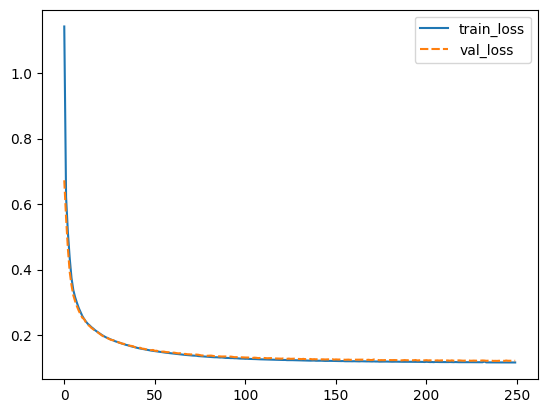

In [35]:
sns.lineplot(history)

In [28]:
test_set = datasets.ImageFolder(
    os.path.join(DATA_DIR, 'test'),
    transform=img_transforms,
)

indices_bad = (torch.tensor(test_set.targets)[..., None] == 0).any(-1).nonzero(as_tuple=True)[0]
indices_good = (torch.tensor(test_set.targets)[..., None] == 1).any(-1).nonzero(as_tuple=True)[0]

test_set_good = Subset(test_set, indices_good)
test_set_bad = Subset(test_set, indices_bad)

test_loader_good = DataLoader(test_set_good, len(indices_good))
test_loader_bad = DataLoader(test_set_bad, len(indices_bad))

ValueError: batch_size should be a positive integer value, but got batch_size=0

In [27]:

with torch.no_grad():
    for data, _ in test_loader_bad:
        data = data.to(DEVICE)
        recon = model(data)
        break

import matplotlib.pyplot as plt
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()


NameError: name 'test_loader_bad' is not defined

In [ ]:
fig.savefig(os.path.join(GRAPH_OUT, NET_NAME + '_anom_sample.png'))

In [ ]:
def pearson_correlation(p1, p2):
    return np.corrcoef(p1.flatten(), p2.flatten(), rowvar=False)[0][1]

good_corr = list(map(pearson_correlation, data.cpu().numpy(), recon.cpu().numpy()))

print(f'Pearson Correlation Coefficients:\n\
    Min: {np.min(good_corr)}\n\
    Median: {np.median(good_corr)}\n\
    Max: {np.max(good_corr)}')

In [ ]:
def euclidean_dist(p1, p2):
    return np.linalg.norm(p1-p2)

dists = list(map(euclidean_dist, data.cpu().numpy(), recon.cpu().numpy()))

print(f'Euclidean Distances:\n\
    Min: {np.min(dists)}\n\
    Median: {np.median(dists)}\n\
    Max: {np.max(dists)}')

In [ ]:
def root_mean_squared_error(p1, p2):
    return np.square(np.subtract(p1, p2)).mean()

def stats(arr):
    """Calculates the IQR of array elements.

    Args:
        arr (np.array): array with numeric values

    Returns:
        float: IQR calculated from quartiles
        float: lower bound for anomaly detection
        float: higher bound for anomaly detection
    """
    q75, q25 = np.percentile(arr, [75, 25])
    iqr = q75 - q25
    return iqr, q25 - 1.5 * iqr, q75 + 1.5 * iqr

iqr, lower_bound, higher_bound = stats(list(map(pearson_correlation, data.cpu().numpy(), recon.cpu().numpy())))

print(f'IQR: {iqr}\nLower Bound: {lower_bound}\nHigher Bound: {higher_bound}')

In [ ]:
with torch.no_grad():
    for img, _ in test_loader_good:
        img = img.to(DEVICE)
        recons = model(img)
        break

plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(img[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recons[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

In [ ]:
fig.savefig(os.path.join(GRAPH_OUT, NET_NAME + '_normal_sample.png'))

In [ ]:
imgs = img.cpu().numpy()
recons_list = recons.cpu().numpy()
    
iqr, lower_bound, higher_bound = stats(list(map(pearson_correlation, img.cpu().numpy(), recons.cpu().numpy())))
print(f'IQR: {iqr}\nLower Bound: {lower_bound}\nHigher Bound: {higher_bound}')

In [ ]:
bad_mse = list(map(pearson_correlation, data.cpu().numpy(), recon.cpu().numpy()))
print(f'Mean Squared Error on Defects:\n\
    Min: {np.min(bad_mse)}\n\
    Median: {np.median(bad_mse)}\n\
    Max: {np.max(bad_mse)}')

In [ ]:
# plt.boxplot(list(map(root_mean_squared_error, img.cpu().numpy(), recons.cpu().numpy())))
# plt.show
import seaborn as sns

fig, ax = plt.subplots(1, 2)
sns.boxplot(list(map(pearson_correlation, data.cpu().numpy(), recon.cpu().numpy())), ax=ax[0])
sns.boxplot(list(map(pearson_correlation, img.cpu().numpy(), recons.cpu().numpy())), ax=ax[1])
fig.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
bxp = sns.boxplot(list(map(pearson_correlation, img.cpu().numpy(), recons.cpu().numpy())))
bxp.set(ylabel='Value', title=f'Pearson Correlation {NET_NAME}')
sns.swarmplot(bad_mse, dodge=True)
ax.hlines(lower_bound, -.3, .3, colors='red')
sns.despine()

In [ ]:
fig.savefig(os.path.join(GRAPH_OUT, NET_NAME + '.png'))